# Chapter 13: Loading and Preprocessing Data with Tensorflow

Until now, we have been dealing with datasets that can fit in memory. However, Deep Learning systems are often trained on very large datasets that will not fit in RAM. **Thus getting large datasets and preprocessing them efficiently becomes an issue**. Thus **Tensorflow makes this whole process easy**, by means of the **Data API**. What you do is this: Create a dataset object, you then tell it where to get the data from and then how the data should be transformed. Tensorflow will take care of the rest. Multithreading, queuing, batching and prefecthing. The Data API also works well with tf.keras

The Data API can read from text-files (e.g CSV files), binary files with fixed-size records and also binary files that use Tensorflow's TFRecord format. This file format supports records of varying sizes. TFRecord is a flexible and efficient binary format based on Protocol Buffers(an open source binary format). In addition to these file types, the Data API also has support for reading from SQL databases. Moreoever, there are many **extensions that are available to read data from different types of data sources** such as **Google's BigQuery Service**

Reading huge datasets efficiently is not the only issue. The data needs to be preprocessed efficiently, and also normalised. In addition to this, the data may not have solely numerical features, there maybe categorical and text features. Thus these need to be encoded. So to do this we have two options:

1. Create custom preprocessing layers

2. Use the standard preprocessing layers provided by Keras.

We will explore both these methods, we will also coverthe DATA API and TFRecord format. In addition will cover some of the following projects:

TF Transform (tf.Transform)
Makes it possible to write a single preprocessing function that can be
run in batch mode on your full training set, before training (to speed it
up), and then exported to a TF Function and incorporated into your
trained model so that once it is deployed in production it can take care
of preprocessing new instances on the fly.


TF Datasets (TFDS)
Provides a convenient function to download many common datasets of
all kinds, including large ones like ImageNet, as well as convenient
dataset objects to manipulate them using the Data API.


## The Data API

The whole Data API is based on the concept of a dataset: a sequence of data items. Often, datasets are gradually read from disk, but for simplicity a dataset can be created in RAM using `tf.data.Dataset.from_tensor_slices()`

Observe the code below:

In [1]:
import tensorflow as tf

#Create a tensor with values between 0 and 9
X = tf.range(10)
#print(X)

#Create a dataset using the from_tensor_slices() method
dataset_original = tf.data.Dataset.from_tensor_slices(X)
dataset_original

<TensorSliceDataset shapes: (), types: tf.int32>

In [2]:
# Loop through the dataset items
for item in dataset_original:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


The `from_tensor_slices()` takes a tensor, X in our case, and creates a `tf.data.Dataset`. The dataset's elements are all slices of X (along the first dimensions i.e x or rows). Thus the dataset contains 10 items with tensors 0,1,..,8,9.

The same dataset can be created using `tf.data.Dataset.range(10)`


### Chaining Transformations


Once you have a dataset, you can apply all sorts of transformations to it by
calling its transformation methods. **Each method returns a new dataset**, so
you can chain transformations like this

In [3]:
#The  2 methods do the following:
#1. Repeat the original data set 3 times. Thus the new dataset has 30 items, ranging between 0-9 in order.
#2. Creates batches of 7. We will have 4 batches with 7 elements and then one batch of 2 elements ,i.e 30/7 = 4 rem 2.
dataset = dataset_original.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


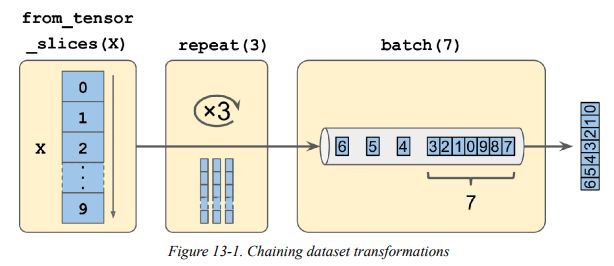

The image above gives a visual representation of what the 2 methods do to the original dataset.

1. Method number 1: `repeat(3)`method returns a new dataset, which repeats the elements of the original dataset 3 times. This new dataset has 30items ranging from 0-9, in order i.e 0-9,0-9,0-9.

2. Method number 2: `batch(7)` method, also creates a new dataset, in which it groups the 30 items from the previous dataset into groups of 7. Thus there are 4 elements of length 7 and 1 element of length 2. If you wanted to keep all elements the same length, include the parameter `drop_remainder = true` in the `batch()` method

-------------------------------------------------------------------------------------------------------------------------------


#### Warning
The dataset methods do not modify datasets, they create new ones, so make sure to keep
a reference to these new datasets (e.g., with dataset = ...), or else nothing will
happen.

-------------------------------------------------------------------------------------------------------------------------------

Another way to apply transformations to datasets would be to use the`map()` method.
In the code example below, a new dataset is created with all the items ofthe original dataset doubled 

In [4]:
dataset = dataset.map(lambda x: x*2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [5]:
dataset_map = dataset_original.map(lambda x: x*2)
for item in dataset_map:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


With this function, you can apply any preprocessing you want to the data. Sometime, the computation maybe quite intensive, so to combat this, you will have to spawn multiple threas to speed things up. This is done by setting the `num_parallel_calls` argument. Finally, the function passed into the `map()` must be convertible into a TF Function.

-------------------------------------------------------------------------------------------------------------------------------
**Note**
If you want to know the number of cores your CPU has: Use the following line of code:

`num_cores = multiprocessing.cpu_count()` Then assign this value to the `num_parallel_calls = num_cores`

or use this an argument = `tf.data.experimental.AUTOTUNE`

-------------------------------------------------------------------------------------------------------------------------------

#### Applying Transformations to the whole dataset

The `map()` function applies a transformation to each item in the dataset. The apply`()` method applies transformations to the data as a whole.  Obcserve the code below:

Each item in the new dataset will be a single-integer tensor
instead of a batch of seven integers:

In [6]:
dataset =  dataset.apply(tf.data.Dataset.unbatch())

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


In [8]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, sh

#### Filtering through a dataset

It is also possible to simply filter the dataset using the `filter()` method

The following code shows us this

In [9]:
dataset_filter = dataset_map.filter(lambda x: x <10)
for item in dataset_filter:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


In [11]:
dataset_filter_2 = dataset_map.filter(lambda x: x >= 10)
for item in dataset_filter_2:
    print(item)

tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


#### Viewing a few items from the dataset

If you want to take alook at a few items from the new dataset, then you can use the `take()`, where the argument is the number of items you wanna see:

Observe:

In [12]:
for item in dataset_filter_2.take(3):
    print(item)

tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)


### Shuffling the Data


The Gradient Descent Algorthim works best when the instances of the data are independent and identically distributed. A simple way to ensure this is to shuffle the instances. This can be done by using the `shuffle()` method. This method takes an argument a buffer_size. This buffer is then filled up with the first items of the source dataset. When the buffer is asked for a new item, it randomly pulls one out from the buffer and replaces this item with a fresh element from the source dataset. It continues to do this until the buffer is empty. It is important to specify the buffer size. It is also vital to ensure to make it large enough in order for shuffling to be effective(**Maybe use `tf.data.experimental.AUTOTUNE`**) to find the right buffer_size. **FIND OUT IF THIS IS FEASIBLE**

The buffer size should not exceed the RAM. Even if there is plenty of it. A Random Seed can be provided as an argument in order to ensure the same random order everytime the program is run. Have a look at the code below:

In [17]:
# Create a dataset with elements ranging between 0-9, repeated 3 times.
dataset = tf.data.Dataset.range(10).repeat(3)

# Shuffle the dataset with a buffer size of 5 and a random seed of 42, then create batches of length 7. 
dataset_shuffled = dataset.shuffle(buffer_size = 5, seed=42).batch(7)

#preview eaach item from the shuffled dataset:
for item in dataset_shuffled:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


For a large dataset that does not fit in memory, this simple shuffling-buffer
approach may not be sufficient, since the buffer will be small compared to
the dataset. One solution is to shuffle the source data itself (for example, on
Linux you can shuffle text files using the shuf command). This will
definitely improve shuffling a lot! Even if the source data is shuffled, you
will usually want to shuffle it some more, or else the same order will be
repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data’s order). To
shuffle the instances some more, a common approach is to split the source
data into multiple files, then read them in a random order during training.
However, instances located in the same file will still end up close to each
other. To avoid this you can pick multiple files randomly and read them
simultaneously, interleaving their records. Then on top of that you can add a
shuffling buffer using the `shuffle()` method

Below is the code example, to load the California Housing Dataset, to split it into training and validation sets and to scale it.

In [ ]:
# Load libraries

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Create an object of fetch_california_housing class

housing = fetch_california_housing

#Review shape of Targets and Features
print(housing.target.shape(), housing.data.shape())

#Split the features and targets into full training and test sets. Reshape targets
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1,1), random_state = 42)

#Split the full training  set into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state = 42)

#Scale the data
# 1.create an obkect of StandardScaler class

scaler = StandardScaler()

#2. Fit training set into scaler object
scaler.fit(X_train)

#3. Get Mean and STD
X_mean = scaler.mean_
X_std = scaler.scale_

For a very large dataset that does not fit in memory, you will typically want to split the source data into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [ ]:
# Create a function to split source data into 20 csv files:
import os

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    #Join two directories: Datasets and housing
    housing_dir = os.path.join("datasets", "housing")
    #Make the directory
    os.makedirs(housing_dir, exist_ok=True)
    #Define path format
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")
    
    #Create an empty filepaths list
    filepaths = []
    #Get length of data(Total number of observations)
    m = len(data)
    
    #Loop through data m times and create n_parts no of csv files.
    # np.array_split(): Split an array into multiple sub-arrays.
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        # Complete the directory path_format: incorparate name_prefix parameter and file index
        part_csv = path_format.format(name_prefix, file_idx)
        #Append the individual filepaths into the filepaths list
        filepaths.append(part_csv)
        
        #Write the data into csv files with the filepaths in the filepaths list
        with open(part_csv, "wt", encoding="utf-8") as f:
            #  Write the headers
            if header is not None:
                f.write(header)
                f.write("\n")
            #Get the data for each column.
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [6]:
# taking a look at what np.array_split does
import numpy as np

m = 30
n = 5

x = np.arange(m)
#print(x)

y = np.array_split(x, n)

#print(y)

for i, idx in enumerate(y):
    print(i, idx)


0 [0 1 2 3 4 5]
1 [ 6  7  8  9 10 11]
2 [12 13 14 15 16 17]
3 [18 19 20 21 22 23]
4 [24 25 26 27 28 29]


In [ ]:
# To use the functio we must do the following:

#1. Concatenate Features and Targets for all sets, along the columns
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]

#2. Join the Target Header name to the headers list
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

#3. Now apply the function to each set.

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [ ]:
# To view the filepaths. You can simply change the name to view filepaths for respective sets.
train_filepaths

### Building the input pipeline

First we create a dataset that contains only the filepaths, using the `list_files()`method from the `tf.data.Dataset` class. Note, the `list_files()` method returns a dataset that shuffles the filepaths. This is good generally speaking, but this can be turned off by `shuffle = False`.

Once that is done, the `interleave()` method is called. This will read from 5 files at a time(this can be tweaked as desired)., and interleave their lines, while skipping the first line of each file as this is the header, using the `skip()` method.

The `interleave()` method will then create a dataset that will pull 5 file paths from the filepath_dataset, and for each one, it will call the function you give it. For this exampe,a lambda function is used to create TextLineDatasets from the dataset created by the `interleave()` method.

Now there should be 7 datasets
1. filepaths_dataset
2. interleave_dataset
3. 5 TextLineDatasets created from interleave dataset

In essence, the interleave dataset will be interated over, where it will cycle through the 5 TextLineDatasets, reading one line at a time until all datasets are out of items. Thereafter, it will go to thenext 5 filepaths from the filepaths_dataset and interleave them in the same way,  this shall continue until it runs out of filepaths

Lets code it out

In [ ]:
#1. Create a filepaths_dataset, which will shuffle the filepaths. note: contains only the filepaths
filepaths_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

#2. Call the interleave method, which will read 5 filepaths at a time from the filepaths_dataset.'
# This interleave function will create 5 TextLineDatasets
n_readers = 5
dataset = filepaths_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),cycle_length=n_readers)

#3. View a few items from the new DS:
for line in dataset.take(5):
    print(line.numpy())

The `interleave()` method does not use parallelism, this can be activated using the num_parallel_calls. This can can be set to `tf.data.experiemental.AUTOTUNE` to dynamically choose the right no of threads.

The dataset will contain byte strings, thus they will need to be parsed and then scaled. Thats done in the next section.

### Preprocessing the Data

In [3]:
import tensorflow as tf
print([0.]*8 + [tf.constant([], dtype=tf.float32)])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>]


Below is a helper function, which is used to perform the preprocessing, i.e parse the data and scale it.

In [ ]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

Lets walk through the code:

1. `defs object`: is an array of default values. Can seen in the code block above the one above this markdown. So the default values will be 8 zeros. One for each feature.

2. `fields object`: Uses the `decode_csv()` method from the `tf.io` API to parse the csv file. This method takes two arguments, one is the line to be parsed and the second is an array containing the default value for each column in the CSV file. This array tells TensorFlow not only the default value for each column, but also the number of columns and their types. So all feature default values are floats and with a value of 0.0 except for the last column(target), hereTF will raise an exception if if it encounters a missing value.

3. The `decode_csv()` function returns a list of scalar tensors(one per column). But we need a 1D tensor arrays. Thus the `tf.stack()` method is called on all the tensors save for thelast one. This will convert the tensors into a 1D array. The same is done for the target value, making it a 1D array with a single value. 

4. Finally each of the features will be scaled using the standardisation technique. we return a tuple containing the scaled features and the target.

### Putting everything together

So, now everything that we have done so far can be combined. It can be combined into asingle helper function to ensure resusability. This helper function will read the data from multiple CSV files, precross it,  shuffle it, repeat it(Optional), batch it and then prefetch it.

This is illustrated in the image below:


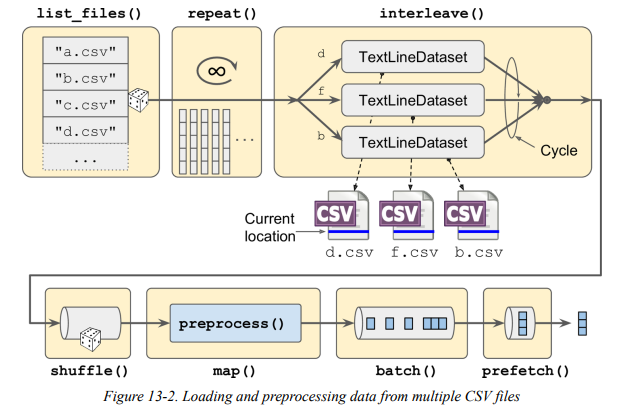

In [ ]:
#Define a dunction to do all the preprocessing and shuffling for us.

def csv_reader_dataset(filepaths, repeat=1,n_readers=5,
                      n_read_threads=None,shuffle_buffer_size=10000,
                      n_parse_threads=5,batch_size=5):
    #Step 1: Create a dataset of filepaths using .listfiles() method and repeat this once(depends on what repeat parameter is assigned to)
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    
    #Step 2: Use the interleave method to read 5 CSV filepaths at a time and create 5 TextLine Datasets.Skip the first line of the CSV-file
    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                cycle_length=n_readers,num_parallel_calls=n_read_threads)
    
    #Step 3: Shuffle the dataset
    dataset = dataset.shuffle(shuffle_buffer_size)
    
    #Step 4: The interleave method will return byte strings. Data needs to be parsed and scaled. Preprocess function is used.
    #        the map() function applies the preprocess function toeach observation.
    
    dataset = dataset.map(preprocess, num_parallel_calls=n_read_threads)
    
    #Step 5: Batch the data into batches of 5 elements
    dataset = dataset.batch(batch_size)
    
    return dataset.prefetch(1)

### Prefetching

Prefetching is used to increase performance. When prefetch is called,we are creating a dataset that will do its best to be one batch ahead.To elaborate: during training, when the training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (i.e reading it from disk and preprocessing it). We can also exploit multiple cores on the CPU by setting `num_parallel_calls` in the `map()` and `interleave()` methods. This can hopefully make preparing one bacth of data shorter than running a training step on the GPU. Thus the GPU is utilized 100% of the time(Training will run mcuh faster).

This is illustrated in the image below:

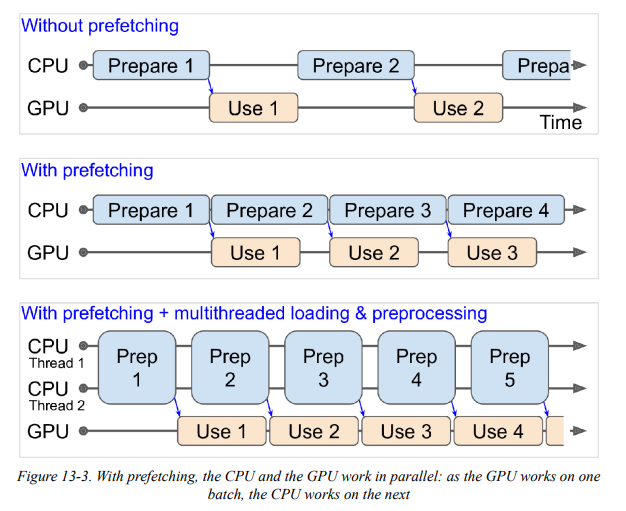

**TIP**

--------------------------------------------------------------------------------------------------------------------------------------
If you plan to purchase a GPU card, its processing power and its memory size are of
course very important (in particular, a large amount of RAM is crucial for computer
vision). Just as important to get good performance is its memory bandwidth; this is the
number of gigabytes of data it can get into or out of its RAM per second.


## The TFRecord Format

-------------------------------------------------------------------------------------------------------------------------------

##### TIP

-------------------------------------------------------------------------------------------------------------------------------
If you are happy with CSV files (or whatever other format you are using), you do not
have to use TFRecords. As the saying goes, if it ain’t broke, don’t fix it! TFRecords are
useful when the bottleneck during training is loading and parsing the data.

-------------------------------------------------------------------------------------------------------------------------------

**This will be done at later stage**

## Preprocessing the Input Features

Preparing your data for a neural network requires all the features to be converted to numerical values, in addition to this, the might need to be scaled, using normalization or even standardization and much more. When we have categorical or text  features, they must also be converted to numerical values. 

There are a few ways to achieve this:

1. Use the normal tools like Pandas, Numpy or Scikit-Learn, to preprocess the data ahead of time.

2. Data can bbe preprocessing on the fly by loading it using the Data API and using the `map()` method.

3. Include a preprocessing layer in the model

The code below will show how a preprocessing layer can be implemented

In [ ]:
# create global mean and std variables
import numpy as np
import tensorflow as tf
from tensorflow.keras import *
from keras import backend
means = np.mean(X_train, axis = 0, keepdims=True)
stds = np.std(X_train, axis = 0, keepdims=True)
eps = keras.backend.epsilon()


#Create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(lambda inputs: (inputs - means)/(stds+epsilon)))
#Create the rest of the model,compile and fit it.

There is another approach, where you can create a custom layer. This custom layer can work just like StandardScaler class from Scikit-Learn

Just not that when using this custom layer, the `adapt()` method has to be called, and passed a data_sample of a few hundred randomly selected training instances. This is so it can get the proper means and stds for each feature.

In [ ]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis = 0, keepdims=True)
        self.stds_ = np.std(data_sample, axis = 0, keepdims=True)
    def call(self, inputs):
        return (inputs-self.means_)/(self.stds_ + keras.backend.epsilon())

In [ ]:
standardization_layer = Standardization()
standardization_layer.adapt(data_sample)

#Now the model can be created as normal

model.add(standardization_layer)

**GOOD NEWS!** Using the **KERAS API**, there is a **Normalization Layer available** that we can use.

### Encoding Categorical Features Using One-Hot Vectors

------------------------------------------------------------------------------------------------------------------------------

#### NOTE

**It should be noted, that the book covers using OneHot Encoding, Embeddings but in addition to this there is the Features API. In in this notebook. All these techniques will be covered to have an overall good understanding on how to deal with categorical and text data. This will also increase the size of my techniques that are available to deal with the aforemetnioned type of data**.

-------------------------------------------------------------------------------------------------------------------------------
Consider the ocean_proximity features from the California Housing data. The feature has 5 categories, which are:

<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"

These categories need to be encoded before they can be used in a neural network. As previously mentioned, there are Scikit-Learn tools readily availbable to solve this but lets consider how to do it using Tensorflow.

Consider the code below:

In [2]:
import tensorflow as tf
#Store the categories in a vocabulary list.
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]

#Create an indices tensor, with elements ranging from 0-4
indices = tf.range(len(vocab), dtype=tf.int64)

#Createan Initializer for the lookup table, maps each category to a value between 0-4
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)

#Create a out of vocabulary buckets variable
num_oov_buckets = 2

#Create the look-up table
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

In [3]:
print(table)

NOTE: I used a `KeyValueTensorInitialzer` here, if I had categories listed in a text file(one category per line), then `TextFileInitialzer` would be used

If we look up a category that does not exist in the
vocabulary, the lookup table will compute a hash of this category
and use it to assign the unknown category to one of the oov
buckets. Their indices start after the known categories, so in this
example the indices of the two oov buckets are 5 and 6.

**As a rule of thumb:  The more unknown categories you expect to find during training, the more oov buckets you should use.**

Lets use the look-up table to encode some features

In [4]:
# Create a categories tensor from a list of categories
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND"])

#Use the look-up table's lookup method, to encode the categories with values between 0-4 for unknown categories unknown categories
cat_indices = table.lookup(categories)

#Print to see the indicies
print(cat_indices)

#One-Hot encode the cat_indices Tensor
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab)+num_oov_buckets)

print(cat_one_hot)

tf.Tensor([3 5 1 1], shape=(4,), dtype=int64)
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]], shape=(4, 7), dtype=float32)


As we can see that from the first tensor; cat_indices, that "DESERT" category is assigned avalue of 5, asit was out ofthe vocabulary. Every other category is given a value corresponding to the index of the category in the vocabulary list.

Then `tf.one_hot()` was used to encode these categories. Notice that we have to tell this function the
total number of indices, which is equal to the vocabulary size plus the
number of oov buckets

The above can be done by create a class. The class's `aadapt()` methodwould take sample data and extract all the distinct categories. Then a lookup table would be created to map eachcategory to its index, and would also include  unknown categories using oov_buckets. The `call()` method would use the lookup able to map input categories to their indices.

But there is a way of doing this built-in into Keras. Use the TextVectorization Layer: `tf.keras.layers.TextVectorization`.
You could add this layer at the beginning of your model,followed by a Lambda layer that would apply the tf.one_hot() function, if you want to convert these indices to one-hot vectors.

This may not bethe best solution though. The size of the one-hot vector plus the oov_buckets can be quite large, when this occurs, it would be prudent to encode them using embeddings instead.

-------------------------------------------------------------------------------------------------------------------------------
**TIP**

As a rule of thumb, if the number of categories is lower than 10, then one-hot encoding
is generally the way to go (but your mileage may vary!). If the number of categories is
greater than 50 (which is often the case when you use hash buckets), then embeddings
are usually preferable. In between 10 and 50 categories, you may want to experiment
with both options and see which one works best for your use case.

-------------------------------------------------------------------------------------------------------------------------------


### Encoding Categorical Features Using Embeddings

An embedding is a trainabledense vector that represent a category. Embeddings are initialised randomnly,by default. Consider the "NEAR BAY"category, initially it might be embedded as [0.131,0.890], while the "NEAR OCEAN" category, might bereresented by the following vector [0.631, 0.791]. These are an example of 2D embeddings.The dimension of the embeddings can be tweaked and is hyperparameter that must be optimized to get the best results. embeddings aretrainbale, hus they will improve during training, in addition, as they represent fairly similar categories, the GD Algo will push them closer together, while moving the unsimilar categories away such as "INLAND". This will help the NN make better, more accurate decisions. **Thus training makes embeddings useful representations of categories**. NOTE: This is called Representation Learning

The image below gives a visual representation of what we just discussed

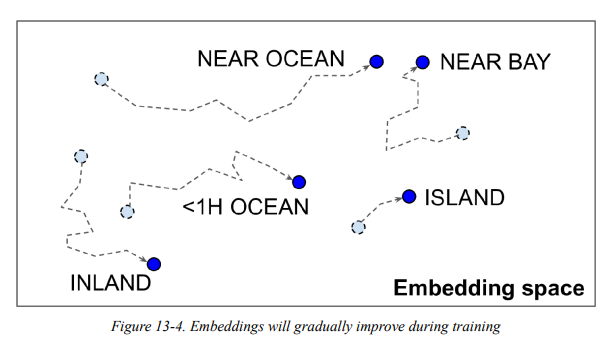

**NOTE FOR WORD EMBEDDINGS**

Not only will embeddings generally be useful representations for the
task at hand, but quite often these same embeddings can be reused
successfully for other tasks. The most common example of this is word
embeddings (i.e., embeddings of individual words): when you are
working on a natural language processing task, you are often better off
reusing pretrained word embeddings than training your own

----------------------------------------------------------------------------------------------------------------------------
Its time to implement the embeddings maunally. Thereafter a Keras Embedding Layer will be used.

**Steps to manually implement embeddings**

1. Create an embedding matrix containing each category's embedding. This should be initialised randomly.
   This matrix will have 1 row per category and per oov bucket, then one column per embedding dimension.
   
2. Use the lookup table we already created to map input categories to corresponding values.

3. Use `tf.nn.embedding_lookup()`. This function looks up the rows in the embedding matrix, at the given indices. Its arguments is the embedding matrix and the categorical indices from the lookup table.

Lets see the above in code

In [6]:
#Step 1: Create the embedding matrix

#Have to define the embedding dimension
embedding_dim = 2

#Randomly initialise the embedding matrix
# Rows dimension: 1 for each known category + number of oov_buckets. #Columns dimension: embedding dimension
embed_init = tf.random.uniform([len(vocab)+num_oov_buckets, embedding_dim])

#Create the embedding matrix as a tf.Variable(Needs to be traininable)
embedding_matrix = tf.Variable(embed_init)

print(embedding_matrix)

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.1979568 , 0.63802195],
       [0.54959905, 0.06085885],
       [0.20520353, 0.05683148],
       [0.46503615, 0.17170954],
       [0.36428463, 0.82262385],
       [0.5096934 , 0.5147195 ],
       [0.26364815, 0.21988654]], dtype=float32)>


In [8]:
#Step 2: Covert input categories to numbers using lookuptable
categories = tf.constant(["NEAR BAY", "DESERT", "INLAND", "INLAND", "LOCATION"])
cat_indices = table.lookup(categories)
print(cat_indices)

tf.Tensor([3 5 1 1 6], shape=(5,), dtype=int64)


In [9]:
# Step 3:Use tf.nn.embedding_lookup()
embedding_layer = tf.nn.embedding_lookup(embedding_matrix, cat_indices)
print(embedding_layer)

tf.Tensor(
[[0.46503615 0.17170954]
 [0.5096934  0.5147195 ]
 [0.54959905 0.06085885]
 [0.54959905 0.06085885]
 [0.26364815 0.21988654]], shape=(5, 2), dtype=float32)


The lookup table says that the "INLAND" category is at index 1, so the `tf.nn.embedding_lookup()` function returns the embedding at row 1 in the embedding matrix (twice): [0.54959905, 0.06085885].

**How to use Keras Embedding Layer**

Keras has an embedding layer available(`tf.keras.layers.Embedding()`. This layer handles the embedding matrix,which trainbale by default.When the layer is created, it is randomly initialised and then when calledwith some category indices, it returns the rows at relevant indices in the embedding matrix.

NOTE: `Input_dim = Length of vocabulary + number of out of vocabulary buckets. Output_dim= Embedding Dimension`

Lets see this in code.

In [10]:
#Create the layer
embedding = tf.keras.layers.Embedding(input_dim = len(vocab)+num_oov_buckets, output_dim=embedding_dim)

#Pass it the input categories in numerical form(indices)
print(embedding(cat_indices))

tf.Tensor(
[[-0.0125724   0.04569573]
 [ 0.0092653   0.04182637]
 [ 0.01614369  0.01987511]
 [ 0.01614369  0.01987511]
 [ 0.04550983  0.0422809 ]], shape=(5, 2), dtype=float32)


Note that the above can be done when creating amodel. Before the embedding layer, siimply add a lambda layer, assing it the table.lookup function as an argument.

In [19]:
#Createa a Functional API model

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

#Create the inputs
num_input = Input(shape=[8])
categories = Input(shape=[], dtype=tf.string)

#Convert the categories to numbers using lookup table
cat_indices = Lambda(lambda cats: table.lookup(cats))(categories)

#Create Embedding Layer
embed_layer = Embedding(input_dim=len(vocab)+num_oov_buckets, output_dim=embedding_dim)(cat_indices)

#Join the embedding layer and numerical features
concat = concatenate([num_input, embed_layer])

#Create adense layer
dense_1 = Dense(1)(concat)

#Build model
model = Model(inputs = [num_input, categories], outputs=dense_1)

#Model Summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None,)              0           input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 2)            14          lambda_5[0][0]                   
_______________________________________________________________________________________

When the keras.layers.TextVectorization layer is available, you can
call its adapt() method to make it extract the vocabulary from a data
sample (it will take care of creating the lookup table for you). Then you can
add it to your model, and it will perform the index lookup (replacing the
Lambda layer in the previous code example).

-------------------------------------------------------------------------------------------------------------------------------
**NOTE**

One-hot encoding followed by a Dense layer (with no activation function and no biases)
is equivalent to an Embedding layer. However, the Embedding layer uses way fewer
computations (the performance difference becomes clear when the size of the
embedding matrix grows). The Dense layer’s weight matrix plays the role of the
embedding matrix. For example, using one-hot vectors of size 20 and a Dense layer with
10 units is equivalent to using an Embedding layer with input_dim=20 and
output_dim=10. As a result, it would be wasteful to use more embedding dimensions
than the number of units in the layer that follows the Embedding layer.

-------------------------------------------------------------------------------------------------------------------------------

**NOTE: Decided not to go over the Features API. It is rather difficult to use and less intuitive. I will comeback to it. As well as TFRecords**

### Using Keras Preprocessing Layers

There are standard Keras preprocessing layers that are availbale. We have discussed the Normalization layer, which is the same as Scikit-Learn's StandardScaler class, which performs standardisation. We have also discussed  TextVectorization layer, which 
maps the word in a vocaublary to its correspondng indices. To use the layers, you have to create an  on=bject of the layer class you wanna use, and call the `adapt()` method, with a data sample. Then use the layer as you would normally use it when constructing a model.

Check the example below:

`norm_layer = tf.keras.layers.Normalization()`

`norm_layer.adapt(data_sample)`

Now the model can be created as normal

`model.add(norm_layer)`

The Keras API also has a Discretization layer. This layer takes continous data and chops it p into bins, and then encodes the bins as one-hot vectors. For example, consider hoousing prices, these might be chopped into 3 bins (low, medium, high), then the one-hot vectors would be [1,0,0], [0,1,0],[0,0,1] respectively. Be careful though, that this may cause some information loss. But it can be useful in detecting patterns, that were not otherwise obvious when looking at the continous data.

**NOTE:**

----------------------------------------------------------------------------------------------------------------------------
Preprocessing layers are non-differentiable, thus meaning during training they arefrozen, since they have no traininable parameters. This means, they should be used at the start of your model. The only preprocessing layer that is trainable is the Embedding Layer. Take Caution, in not using this layer in a custom preprocessing layer.

------------------------------------------------------------------------------------------------------------------------------

It is also possible to chain mutliple preprocessing layers using the `PreprocessingStage()`. Basically creating a preprocessing pipeline. Remember though, the adapt() method must be called on the pipeline on a data sample. Also, use use at the start of the model since it conatins non-differentiable layers.

Observe the code below:

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import *

normalization_layer = Normalization()
discretization_layer = Discretization([a for a in range(100)])
pipeline = PreprocessingStage([normalizaing_layer, discretization_layer])
#pipeline.adapt(data_sample)

Keras preprocessing layers, make it easy to preprocess data. In addition to this, we can also write our own custom preprocessing layers. All the preprocessing will happen on the fly. However, during training, it maybe preferable to perform preprocessing ahead of time. **TFTransform** helps us do this. lets see how

## TFTransform

If preprocessing is computationally expensive, then preprecossing the data before training rather than on the fly maybe a better option to speed up training. This is because, when data is preprocessed on the fly, it is preprocessed once per instance AND per epoch during training. Whereas, if it is preprocessed before training, it is preprocessed, once per instance before training.

Secondly, if you have large dataset, that cannot fit into memory, there are tools like **Apache Beam and Spark**. **These tools allows to write effective and efficient data pipelines over large amounts of data**. These can even be distributed across multiple servers, thus you can use them to preprocess all the data before training. 

However, what if the model is to be deployed on a mobile app and on a web browser. This would require there to be preprocessing code on the mobile app code, and also on the Tensorflow-js model to be run in a web  browser. This can cause issues with regards to maintainence, as changes to preprocessing logic, would result in having to implement changes to the Apache Beam code, The mobile app code, and also the tfjs code. This approach is error prone. 

As a solution, there is TFtransform, which is a component of Tensorflow Extended(TFX). This an end-to-end platform used to productionise Tensorflow models. **With TFTransform, one can write preprocessing operations just once**. To use a TFX component, such as TFTransfor:

1. You must install it first.

2. Define your preprocessing function ,just once(Python), by using Tf Transform  fuctions for scaling, bucketizing and more. In addition, any Tensorflow Operation can work.

The code below illustrated the above:

In [ ]:
#step 1 : Install Tensorflow Transform

import tensorflow_transform as tft
#If it is not installed, try pip3 install -U tensorflow-transform

#step 2: Define the preprocessing function
def preprocess(inputs):
    #Function uses tft functions to obtain the standardized median age and 
    #Gets the vocabulary indices for a categroical feature on the dataset
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age-tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized age": standardized_age,
        "ocean proximity id": ocean_proximity_id
    }

TF Transform will then allow us to apply this `preprocess()` function to the whole training set using Apache Beam, this is done using `AnalyzeAndTransformDataset` class in the Apache Beam pipeline. In addition, during the aforemention process, the necessary statsistics over the whole training set are calculated. The components that do these calculations are called analyzers. For example, the mean and standard deviation of the housing_median_age and vocabulary for the ocean_proximity feature.

TF Transform will also generate an equivalent TensorFlow Function that you can plug into the model that is deployed. The TF Function will include constants that correspond to the necessary stats computed by Apache Beam(mean, STD, vocabulary)


With the Data API, TFRecords, the Keras preprocessing layers, and TF Transform, you can build highly scalable input pipelines for training and benefit from fast and portable data preprocessing in production.
But what if you just wanted to use a standard dataset? Well in that case, things are much simpler: just use TFDS

## Tensorflow Dataset (TFDS) Project

-----------------------------------------------------------------------------------------------------------------------------

The Tensorflow Datasets project makes it easyto get access to commonly used datasets, such as MNIST, Fashion MNIST, ImageNet, audio, text(including translational) and video datasets. In order to view a full list along with a descrition of the dataset visit the following link: https://homl.info/tfds

To use the TFDS, you have to pip install it, as it is not bundled with Tensorflow. Once installed, it must be imported and then you use the `tfds.load()` method to access the dataset you want to use. This will download the dataset, and will return a dictionary of datasets: one of trainings and one for testing. This depends on the dataset you want to use. 

Once the data is loaded, different transformations maybe applied at will. But typically we apply shuffling, batching and prefetching. Once that is done, you can train the model

The code below illustrates the above:

In [ ]:
#Import the library
import tensorflow-datasets as tfds

#Assign the dataset object the dictionary of datasets the .load() metjod returns
dataset = tfds.load("mnist")

#Get the separate a datasets

mnist_train, mnist_test = dataset["train"], dataset["test"]

#Apply transformations
mnist_train = mnist_train.shuffle(10000).batch(32).prefetch(1)

Its important to note that in the dataset, each item is s dictionary containing both the feature and the label. Keras, howver, expects each item to be a tuple containing( the features and labels). This transformation from  dictionary to tuple can be done using the `map()` method

Check out the code below:

In [ ]:
mnist_train = mnist_train.shuffle(10000).batch(32)

mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))

mnist_train = mnist_train.prefecth(1)

Another simpler method, THAT WORKS FOR LABELLED DATASETS,is to set the `as_supervised=True` parameter in the `load()` function. Addition, to this, one can aso specify the batch_size within the`load()` method. 

In [ ]:
dataset = tfds.load("mnist", batch_size =32, as_supervised = True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

In [ ]:
#To get the list of all datasets available:
print(tfds.list_builders())

Deep Learning often involves large amounts of data, and knowing how to load, parse, and preprocess it efficiently is a crucial skill to have. In the next chapter, we will look at convolutional neural networks, which are among the most successful neural net architectures for image processing and many other applications

## Exercises

-------------------------------------------------------------------------------------------------------------------------------

### Question 1

1. Why would you want to use the Data API?

-----------------------------------------------------------------------------------------------------------------------------

The DATA API would be used to get large datasets and efficiently preprocess them. The DATA API makes this process easy. In addition, it has features, such loadin data from multiple different sources, in different formats. In addition, there are a multitude of operations that maybe done on the data to efficiently preprocess it, such shuffling, batching it, interleaving it etc


### Question 2

2. What are the benefits of splitting a large dataset into multiple files?

-----------------------------------------------------------------------------------------------------------------------------

When you are working with a large dataset that does not fit into memory, the shuffle buffer method will not suffice. Thus as an alternative, one approach would be to split the source data into mutliple files. Then shuffle the instances some more, by picking some multiple files at random, read them simultaneously and interleave their records. This will effectively shuffle the data, and the benefit of this is that the GradientDescent Algorithm works best when the instances of the data are independent and identically distributed.

Splitting a large dataset into multiple files makes it possible to shuffle it at a coarse level before shuffling it at a finer level using a shuffling buffer. It also makes it possible to handle huge datasets that do not fit on a single machine. It’s also simpler to manipulate thousands of small files rather than one huge file.


### Question 3

3. During training, how can you tell that your input pipeline is the bottleneck? What can you do to fix it?

-------------------------------------------------------------------------------------------------------------------------------

You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches. If this is insufficient to get your GPU to 100% usage during training, make sure your preprocessing code is optimized.You can also try saving the dataset into multiple TFRecord files,and if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this). If necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.

-------------------------------------------------------------------------------------------------------------------------------

## NOTE: Q4-Q6 Deal with TFREcords, which were not covered in this notebook

-------------------------------------------------------------------------------------------------------------------------------

### Question 7

7. Data can be preprocessed directly when writing the data files, or within the tf.data pipeline, or in preprocessing layers within your model, or using TF Transform. Can you list a few pros and cons of each option?

------------------------------------------------------------------------------------------------------------------------------


1. **Preprocessing when writing files**

    *Pros:*
    
    If the data is preprocessed while creating the files, the trainin script will run faster since trainin is not done on the fly during training. Secondly, preprocessed files, tend to be smaller than the original files. Therefore, this could speed up the download and free up some space. It maybe useful to materialise the preprocessed data, like archiving it or inspect it
    
    *Cons:*
    
    First, it’s not easyto experiment with various preprocessing logics if you need to generate a preprocessed dataset for each variant. Second, if you want to perform data augmentation, you have to materialize many variants of your dataset, which will use a large amount of disk space and take a lot of time to generate. Lastly, the trained model will expect preprocessed data, so you will have to add preprocessing code in your application before it calls the model
    
    
2. **Within a tf.data pipeline**

    *Pros:*
    
    Using a tf.data pipelie, it is much easier to change the preprocessin logic and apply data augmentation. It is also easir to build efficient preprocessing pipelines usingmultithreadin and prefecthing.
    
    *Cons:*
    
    Using tf.data pipelines can slow trainin down,as preprocessing is done on the fly. Each instance will be preprocessed once per epoch rather than once if the data was preprocessed when creating the file. The model will still epect preprocessed data.
    
    
3. **In Preprocessing Layers**

    *Pros:*
    
    If preprocessing layers are included in the model, then preprocessing code has to be written once, for training and inference. If your model is deployed onto different platforms, there is no need to write preprocessing code multiple times as it is part of the model. Finally, there is no risk of writing the wrong preprocessing logic for the model, as the layers are aprt of the model
    
    *Cons:*
    
    Having preprocessing layers does slow down training, each training obervation will be preprocessed once per epoch. Since the preprocessing is part of the model, one cannot make use of prefecthing and multithreading, to help speed up training. However, according to the author, there are upcoming Keras preprocessing layers, that will lift the preprocessing operations  from the preprocessing layers and run them as part of a tf.data pipeline,from there multithreading and prefecthing can be used. Pretty Neat.
    
    
4. **Using TFTransform**

    *Pros:*
    
    TFTRansform preprocessing has many benefits that theprevious methods have: such as the preprocessed data is materialized, each instance is preprocessed once, which in turn speeds up training and preprocessing layers get generated automatically. This allowsfor preprocessing code to be written once. 
    
    *Con:*
    
    The only con is that one has to learn how to use TFTRansform
    
    
### Question 8

8. Name a few common techniques you can use to encode categorical features. What about text?

------------------------------------------------------------------------------------------------------------------------------

**Categorical Features:**

If the feature has a natural order or  is used as a ranking metric, thenthe best encoding to usewould be Ordinal Encoding,,as the categorical variables are were measured using an ordinal scale. For example consider movie reviews (Bad, Average, Good) would be encode as follows:  (“bad” maps to 0, “average” maps to 1, and “good” maps to 2).

However most categorical features, have no natural order, so one-hot encoding would be sufficient, but if there are many categories, then using embeddings would be the best solution.

**Text**

When dealing with text, one can use the bag-of-words representation: A sentence is represented by a vector counting the counts of each possible word.**NOTE:bag-of_words completely loses the order of the words**. Common words are usually not important, thus use TermFrequency × Inverse-Document-Frequency (TF-IDF) to reduce their weight. 

Another approach would be to use n-grams. Which are sequences of n-consecutive words, this approach is nice and simple.

Another alternative, would be to use pretrained word embeddings, finally one can also opt for the option to encode each latter or subword tokens. (e.g splitting “smartest” into “smart” and “est”).


### Question 10

In this exercise you will download a dataset, split it, create a tf.data.Dataset to load it and preprocess it efficiently, then
build and train a binary classification model containing an Embedding layer

### a. 

Download the Large Movie Review Dataset, which contains 50,000 movies reviews from the Internet Movie Database. The data is organized in two directories, train and test, each containing a pos subdirectory with 12,500 positive reviews and a neg subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise.


In [ ]:
# Download the file
from pathlib import Path
from tensorflow import keras


#Get url the data is hosted on
DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"

#The dataset filename
FILENAME = "aclImdb_v1.tar.gz"

#Now to download and extract the dataset from the directory
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)

#Create a path to the file
path = Path(filepath).parent/ "aclImdb"
path

from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

In [ ]:
#Lets view the structure of the file we downloaded from the url
#As stated, the data has 2 directories, containing test and training data.
#Both these have negative and positive review textfiles in subdirectories.

import os

for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print("    "*indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("   " * (indent + 1) + filename)

In [ ]:
#Finally lets get the training and test positive and negative reviews

# Create a  function that will grab the different reviews from the different sets and put them into a list.
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

# Get the Training Positive Reviews
train_pos = review_paths(path / "train" / "pos")

# Get the Training Negative Reviews
train_neg = review_paths(path / "train" / "neg")

# Get the Test Positive Reviews
test_valid_pos = review_paths(path / "test" / "pos")

# Get the Test Negative Reviews
test_valid_neg = review_paths(path / "test" / "neg")

# Lets view how many entries are in each list

print("Number of Positive Training Reviews: ", len(train_pos), "Number of Negative Training Reviews:", len(train_neg))
print("Number of Positive Test Reviews: ", len(test_valid_pos), "Number of Negative Test Reviews:", len(test_valid_neg))

### b. 

Split the test set into a validation set (15,000) and a test set
(10,000).

In [ ]:
#Shufflle the full test set reviews
import numpy as np
np.random.shuffle(test_valid_pos)
np.random.shuffle(test_valid_neg)

# Create the validation set
validation_pos = test_valid_pos[:7500]
validation_neg = test_valid_neg[:7500]

# Create the test set
test_pos = test_valid_pos[7500:]
test_neg = test_valid_neg[7500:]

### c.

Use tf.data to create an efficient dataset for each set.

Since the dataset fits in memory, we can just load all the data using pure Python code and use `tf.data.Dataset.from_tensor_slices()`:

In [ ]:
# Create a function to create a tf.data dataset
import tensorflow as tf
def imdb_dataset(filepaths_positive, filepaths_negatives):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
            (tf.constant(reviews),tf.constant(labels)))

In [18]:
#Test how the above for loops work
names = []
ages = []

db_1 = [("Saul",20),("Shawn",25),("Sive",30),("Lathi",21),("Zane",36),("Roger",20),("Ken",27)]
db_2 = [("Cristina",20),("Carol",56),("Asive",25),("Alice",24),("Kendell",30),("Janice",20),("Mary",32)]


for i in range(7):
    names.append(db_1[i][0])
    names.append(db_2[i][0])
    ages.append(db_1[i][1])
    ages.append(db_2[i][1])

In [19]:
print(names)

['Saul', 'Cristina', 'Shawn', 'Carol', 'Sive', 'Asive', 'Lathi', 'Alice', 'Zane', 'Kendell', 'Roger', 'Janice', 'Ken', 'Mary']


In [20]:
print(ages)

[20, 20, 25, 56, 30, 25, 21, 24, 36, 30, 20, 20, 27, 32]


In [ ]:
for X, y in imdb_dataset(train_pos, train_neg).take(5):
    print(X)
    print(y)
    #print()

In [ ]:
# Apply some transformations to the dataset 
# Shuffle the training set
# Create batches of size 32
# Prefetch the data

batch_size = 32
training_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
validation_set =imdb_dataset(validation_pos, validation_neg).batch(batch_size).prefetch(1)
test_set =imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

### d. 

Create a binary classification model, using a `TextVectorization` layer to preprocess each review. If the `TextVectorization` layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the `tf.strings` package, for example `lower()` to make everything lowercase, `regex_replace()` to replace punctuation with spaces, and `split()` to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the `adapt()` method.

#### 1.

Let's first write a function to preprocess the reviews, cropping them to 300 characters, converting them to lower case, then replacing `<br />` and all non-letter characters to spaces, splitting the reviews into words, and finally padding or cropping each review so it ends up with exactly `n_words` tokens:

In [ ]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch)*tf.constant([1,0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    # Make all words lower case
    Z = tf.strings.lower(Z)
    #Replace puncutation and numbers with spaces
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    #Split words on spaces
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape = shape, default_value ="b<pad>")

In [ ]:
#Test out the function
X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)